In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#hiding warning messages
import warnings
warnings.filterwarnings("ignore")

In [4]:
#importing RDKIT fingerprinting software
from __future__ import print_function
import rdkit
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols


In [31]:
#Reading in Summary ANTAGONIST CSV
data = pd.read_csv('AID_720725_datatable_all.csv')
data = data.iloc[2:]
data = data.reset_index()
data.head(10)

,index,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Activity Summary,Ratio Activity,...,530 nm Activity,530 nm Potency (uM),530 nm Efficacy (%),460 nm Activity,460 nm Potency (uM),460 nm Efficacy (%),Viability Activity,Viability Potency (uM),Viability Efficacy (%),Sample Source
0,2,RESULT_UNIT,NaN,NaN,NaN,NaN,NaN,NaN,NONE,NONE,...,NONE,MICROMOLAR,PERCENT,NONE,MICROMOLAR,PERCENT,NONE,MICROMOLAR,PERCENT,NONE
1,3,1,144203552.0,12850184.0,Inactive,0.0,NaN,NaN,inactive,inactive,...,inactive,NaN,0,inactive,NaN,0,inactive,NaN,0,NCI
2,4,2,144203553.0,89753.0,Inactive,0.0,NaN,NaN,inactive,inactive,...,inactive,NaN,0,inactive,NaN,0,inactive,NaN,0,NCI
3,5,3,144203554.0,9403.0,Active,57.0,NaN,NaN,active antagonist,active antagonist,...,inactive,NaN,0,active antagonist,7.56242,-95.0751,inconclusive antagonist,NaN,0,NCI
4,6,4,144203555.0,13218779.0,Inactive,0.0,NaN,NaN,inactive,inactive,...,inactive,NaN,0,inactive,NaN,0,inactive,NaN,0,NCI
5,7,5,144203556.0,142766.0,Inactive,0.0,NaN,NaN,inactive,inactive,...,inactive,NaN,0,inactive,NaN,0,inactive,NaN,0,NCI
6,8,6,144203557.0,16043.0,Inactive,0.0,NaN,NaN,inactive,inactive,...,inactive,NaN,0,inactive,NaN,0,inconclusive antagonist,NaN,0,NCI
7,9,7,144203558.0,16043.0,Inconclusive,25.0,NaN,NaN,inconclusive antagonist (cytotoxic),active antagonist,...,inconclusive antagonist,23.9145,-61.7417,active antagonist,17.5925,-145.137,active antagonist,23.9145,-99.9932,SigmaAldrich
8,10,8,144203559.0,2724411.0,Inconclusive,25.0,NaN,NaN,inconclusive antagonist (cytotoxic),inconclusive antagonist,...,inactive,NaN,0,inconclusive antagonist,16.9301,-132.937,inconclusive antagonist,12.6958,-45.2176,NCI
9,11,9,144203560.0,2724372.0,Inactive,0.0,NaN,NaN,inactive,inactive,...,inactive,NaN,0,inactive,NaN,0,inactive,NaN,0,NCI


In [32]:
#Finding CID Duplicates
data_dupsCID = data.pivot_table(index=['PUBCHEM_CID'], aggfunc='size')
#print (data_dupsCID)

# Counts and Figures

In [33]:
#Total Counts for Active/Inconclusive/Active
activity_counts = data['PUBCHEM_ACTIVITY_OUTCOME'].value_counts()
activity_counts.iloc[0:3]

Inactive        7744
Inconclusive    2282
Active           460
Name: PUBCHEM_ACTIVITY_OUTCOME, dtype: int64

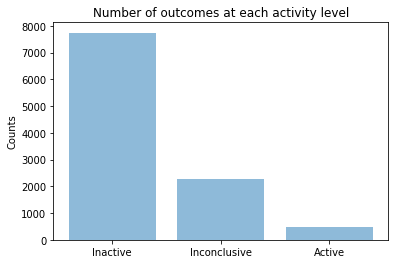

In [34]:
#Bar graph of Activity Outcome Counts
outcomes = ('Inactive', 'Inconclusive', 'Active')
y_pos = np.arange(len(outcomes))
counts = (activity_counts.iloc[0], activity_counts.iloc[1], activity_counts.iloc[2])

plt.bar(y_pos, counts, align = 'center', alpha = 0.5)
plt.xticks(y_pos, outcomes)
plt.ylabel('Counts')
plt.title('Number of outcomes at each activity level')

plt.show()

In [35]:
#Dataframe of ALL Activity Scores
allscores = data['PUBCHEM_ACTIVITY_SCORE']

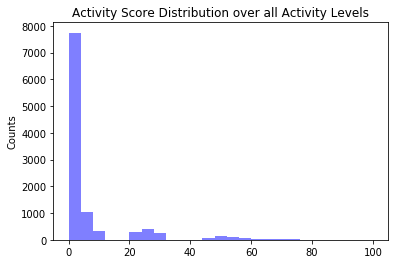

In [36]:
#Histogram of ALL Activity Scores
x = allscores
num_bins = 25
n, bins, patches = plt.hist(x, num_bins, facecolor = 'blue', alpha = 0.5)
plt.ylabel('Counts')
plt.title('Activity Score Distribution over all Activity Levels')
plt.show()

In [37]:
#Dataframe of all Active molecules, col1 is index and col2 is activity score
#Activity score range of 40-100
active = data['PUBCHEM_ACTIVITY_SCORE'].where(data['PUBCHEM_ACTIVITY_OUTCOME'] == 'Active')
active = active.dropna()

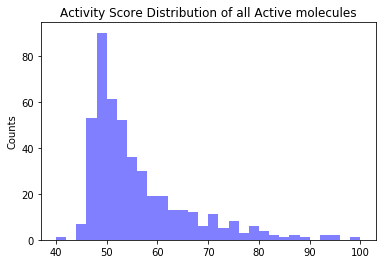

In [38]:
#Histogram of distribution of Active activity scores (460)
x = active
num_bins = 30
n, bins, patches = plt.hist(x, num_bins, facecolor = 'blue', alpha = 0.5)
plt.ylabel('Counts')
plt.title('Activity Score Distribution of all Active molecules')
plt.show()

In [40]:
#Dataframe of all Inconclusive molecules, col1 is index and col2 is activity score
#Activity score range of 5-30
inc = data['PUBCHEM_ACTIVITY_SCORE'].where(data['PUBCHEM_ACTIVITY_OUTCOME'] == 'Inconclusive')
inc = inc.dropna()


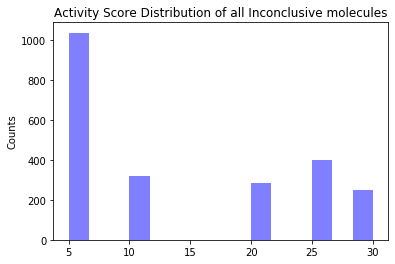

In [41]:
#Histogram of distribution of Inconclusive activity scores (2282, all by multiples of 5?)
x = inc
num_bins = 15
n, bins, patches = plt.hist(x, num_bins, facecolor = 'blue', alpha = 0.5)
plt.ylabel('Counts')
plt.title('Activity Score Distribution of all Inconclusive molecules')
plt.show()

In [42]:
#Dataframe of all Inactive molecules, col1 is index and col2 is activity score (7744)
#Activity scores are only 0
inact = data['PUBCHEM_ACTIVITY_SCORE'].where(data['PUBCHEM_ACTIVITY_OUTCOME'] == 'Inactive')
inact = inact.dropna()

# Variable Correlations

In [55]:
#Trying to correlate Activity Score and Potency (for Active and Inconclusive molecules) (2742)
##df active and inconclusive
act_inc = pd.concat([active, inc])

#Obtaining potency values for active and inconclusive molecules
act_pot = data['Ratio Potency (uM)'].where(data['PUBCHEM_ACTIVITY_OUTCOME'] == 'Active')
act_pot = act_pot.dropna()

inc_pot = data['Ratio Potency (uM)'].where(data['PUBCHEM_ACTIVITY_OUTCOME'] == 'Inconclusive')
inc_pot = inc_pot.dropna()

#Combining data into one potency df with active and inconclusive molecules
act_inc_pot = pd.concat([act_pot, inc_pot])

In [65]:
#Creating one DF with activity score and potency as columns 
#dropping nan values
score_and_pot = {"activity score":act_inc, "potency": act_inc_pot}
df_total = pd.DataFrame(score_and_pot)
df_total = df_total.dropna()

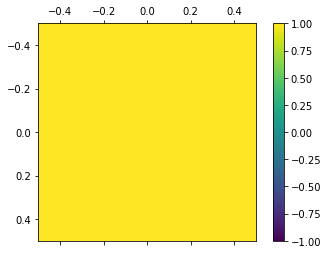

In [73]:
correlations = df_total.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin = -1, vmax = 1)
fig.colorbar(cax)
ticks = np.arange(0, 2, 1)
plt.show()